# Variability analysis

Analyse the effect of parameter changes and double parameter changes on the output of given simulation.

In [1]:
# import and setup database
import django
django.setup()
# import the database API functions and tools
import simapp.db.api as db_api
import multiscale.odesim.db.tools as db_tools

In [3]:
# create model in database
from multiscale.examples.testdata import demo_filepath
print(demo_filepath)
comp_model = db_api.create_model(filepath=demo_filepath)

/home/mkoenig/multiscale-galactose/python/multiscale/multiscale/examples/models/demo/Koenig_demo_v02.xml


In [4]:
comp_model

<CompModel: <SBML: Koenig_demo_v02>>

In [7]:
import roadrunner
roadrunner.getVersionStr()

'1.3.2; Compiler: gcc 4.8.2, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: May 22 2015, 16:37:07'

['time', '[A]', '[B]', '[C]', '[A_ext]', '[B_ext]', '[C_ext]']


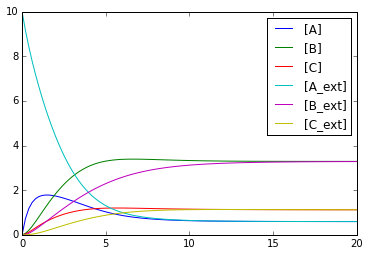

In [9]:
%matplotlib inline
# Uset the filepath from the database
rr = roadrunner.RoadRunner(comp_model.filepath)
rr.selections = ['time'] + ['[{}]'.format(s) for s in rr.model.getFloatingSpeciesIds()]
print rr.selections
s = rr.simulate(0,20, 100, plot=True)  # equidistant timecourse for 20 [s]

## Parameter variability analysis

Vary all single parameters in the model between [0.95-1.05] the original value.

In [10]:
# These are the parameters to vary
parameter_ids = rr.model.getGlobalParameterIds()
parameter_ids

['scale_f',
 'Vmax_bA',
 'Km_A',
 'Vmax_bB',
 'Km_B',
 'Vmax_bC',
 'Km_C',
 'Vmax_v1',
 'Keq_v1',
 'Vmax_v2',
 'Vmax_v3',
 'Vmax_v4',
 'Keq_v4']

In [11]:
# get units from the sbml
import libsbml
doc = libsbml.readSBML(demo_filepath)
sbml_model = doc.getModel()
units = {}
for pid in parameter_ids: 
    p = sbml_model.getParameter(pid)
    unit = p.getUnits()
    units[pid] = unit
units

{'Keq_v1': 'dimensionless',
 'Keq_v4': 'dimensionless',
 'Km_A': 'mM',
 'Km_B': 'mM',
 'Km_C': 'mM',
 'Vmax_bA': 'mole_per_s',
 'Vmax_bB': 'mole_per_s',
 'Vmax_bC': 'mole_per_s',
 'Vmax_v1': 'mole_per_s',
 'Vmax_v2': 'mole_per_s',
 'Vmax_v3': 'mole_per_s',
 'Vmax_v4': 'mole_per_s',
 'scale_f': 'dimensionless'}

In [12]:
# get the original values for all parameters
values = {pid: rr[pid] for pid in parameter_ids}
values

{'Keq_v1': 10.0,
 'Keq_v4': 2.0,
 'Km_A': 1.0,
 'Km_B': 0.5,
 'Km_C': 3.0,
 'Vmax_bA': 5.0,
 'Vmax_bB': 2.0,
 'Vmax_bC': 2.0,
 'Vmax_v1': 1.0,
 'Vmax_v2': 0.5,
 'Vmax_v3': 0.5,
 'Vmax_v4': 0.5,
 'scale_f': 1e-06}

In [13]:
# now we can setup the single variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
factors = [0.90, 1.10]
samples = []
for pid in parameter_ids:
    for f in factors:
        # create an empty sample
        s = Sample()
        # Set the parameters to the values
        sp = SampleParameter(pid, f * rr[pid], unit=units[pid], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
        s.add_parameter(sp)
        samples.append(s)

samples

[{'scale_f': <scale_f = 9.000E-07 [dimensionless] (GLOBAL_PARAMETER)>},
 {'scale_f': <scale_f = 1.100E-06 [dimensionless] (GLOBAL_PARAMETER)>},
 {'Vmax_bA': <Vmax_bA = 4.500E+00 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Vmax_bA': <Vmax_bA = 5.500E+00 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Km_A': <Km_A = 9.000E-01 [mM] (GLOBAL_PARAMETER)>},
 {'Km_A': <Km_A = 1.100E+00 [mM] (GLOBAL_PARAMETER)>},
 {'Vmax_bB': <Vmax_bB = 1.800E+00 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Vmax_bB': <Vmax_bB = 2.200E+00 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Km_B': <Km_B = 4.500E-01 [mM] (GLOBAL_PARAMETER)>},
 {'Km_B': <Km_B = 5.500E-01 [mM] (GLOBAL_PARAMETER)>},
 {'Vmax_bC': <Vmax_bC = 1.800E+00 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Vmax_bC': <Vmax_bC = 2.200E+00 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Km_C': <Km_C = 2.700E+00 [mM] (GLOBAL_PARAMETER)>},
 {'Km_C': <Km_C = 3.300E+00 [mM] (GLOBAL_PARAMETER)>},
 {'Vmax_v1': <Vmax_v1 = 9.000E-01 [mole_per_s] (GLOBAL_PARAMETER)>},
 {'Vmax_v1': <Vmax_v1 = 1.100E+00 [mole_per

In [14]:
# We want step based integration in the interval [0.0, 20.0]
settings_dict = {db_api.SettingKey.VAR_STEPS: False,\
                 db_api.SettingKey.T_START: 0.0,\
                 db_api.SettingKey.T_END: 20.0, \
                 db_api.SettingKey.STEPS: 100}

# For the tolerances, ... we use the default settings
settings = db_api.create_settings(settings_dict)
for setting in settings:
    print(setting)

INTEGRATOR = ROADRUNNER
VAR_STEPS = False
ABS_TOL = 1e-06
REL_TOL = 1e-06
T_START = 0.0
T_END = 20.0
STEPS = 100
STIFF = True


In [15]:
method = db_api.create_method(method_type=db_api.MethodType.ODE, settings=settings)

In [16]:
task = db_api.create_task(comp_model, method=method, info="Single parameter variation {}.".format(factors))

In [19]:
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations = db_tools.create_simulations_from_samples(task, samples)
    # finalize task, so no additional simulations can be added
    task.finalize_status()
except ValidationError:
    simulations = task.simulations.all()
simulations
print('TaskStatus:', task.status_str)

('TaskStatus:', 'FINALIZED')


In [20]:
len(simulations)

26

### Solve the ODE system

Now we are running the solver on the defined problems.

In [22]:
from multiscale.odesim.simulate import solve

In [23]:
solve.run_simulations(simulations, task)

Loading : /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo_v02.xml
SBML load time: 0.038507938385
Time: [0.0317|0.0031]
Time: [0.0133|0.0012]
Time: [0.0159|0.0010]
Time: [0.0150|0.0013]
Time: [0.0126|0.0009]
Time: [0.0146|0.0012]
Time: [0.0151|0.0012]
Time: [0.0140|0.0010]
Time: [0.0141|0.0015]
Time: [0.0136|0.0011]
Time: [0.0156|0.0010]
Time: [0.0137|0.0012]
Time: [0.0118|0.0010]
Time: [0.0167|0.0020]
Time: [0.0172|0.0017]
Time: [0.0141|0.0011]
Time: [0.0142|0.0015]
Time: [0.0170|0.0020]
Time: [0.0173|0.0016]
Time: [0.0129|0.0010]
Time: [0.0121|0.0012]
Time: [0.0172|0.0018]
Time: [0.0176|0.0018]
Time: [0.0129|0.0010]
Time: [0.0122|0.0012]
Time: [0.0136|0.0016]


In [24]:
# plot the results
from simapp.models import Result
import matplotlib.pylab as plt
plt_fontsize = 30

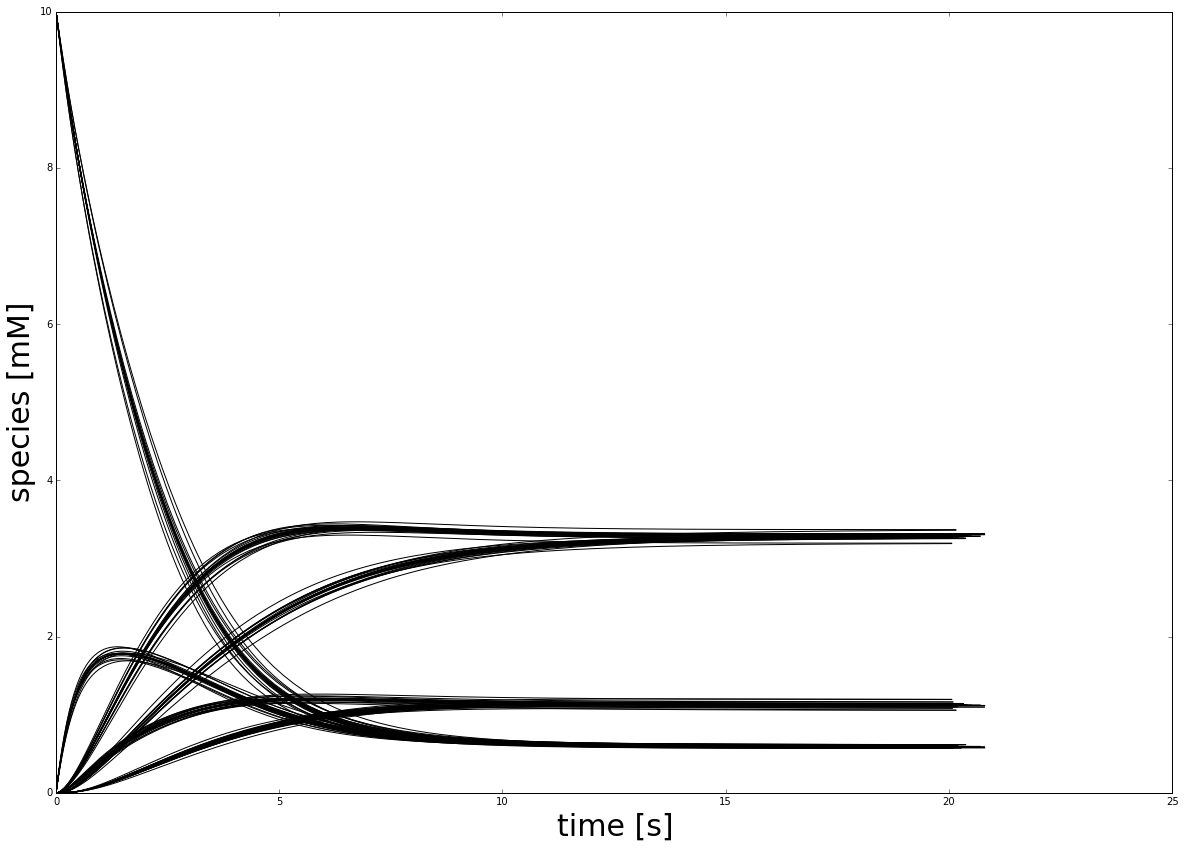

In [26]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize);

## Double parameter variation

For comparison all double parameter changes in the model are performed.  
How much larger are the combined effects of parameter changes?

In [27]:
# now we can setup the double variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
samples_double = []
for pid1 in parameter_ids:
    for pid2 in parameter_ids:
        if pid1 == pid2:
            continue
        for f1 in factors:
            for f2 in factors:
        
                # create an empty sample
                s = Sample()
                # Set first parameter
                sp1 = SampleParameter(pid1, f1 * rr[pid1], unit=units[pid1], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                # Set second parameter
                sp2 = SampleParameter(pid2, f2 * rr[pid2], unit=units[pid2], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                s.add_parameters([sp1, sp2])
                samples_double.append(s)
print('Number of parameters:', len(parameter_ids))                
print('Number of samples:', len(samples_double))

('Number of parameters:', 13)
('Number of samples:', 624)


In [28]:
task_double = db_api.create_task(comp_model, method=method, info="Double parameter variation {}.".format(factors))

In [29]:
# Removing objects from the database
# from simapp.models import Task
# task_temp = Task.objects.get(pk=64)
# task_temp.delete()
# task_double.info = "Double parameter variation {}.".format(factors)
# task_double.save()

In [30]:
print('TaskStatus:', task.status_str)
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations_double = db_tools.create_simulations_from_samples(task_double, samples_double)
    # finalize task, so no additional simulations can be added
    task_double.finalize_status()
except ValidationError:
    simulations_double = task_double.simulations.all()
simulations
print('TaskStatus:', task.status_str)

('TaskStatus:', 'FINALIZED')
('TaskStatus:', 'FINALIZED')


In [32]:
import time
start = time.time()
solve.run_simulations(simulations_double, task_double)
duration = time.time() - start
print('Total time:', duration)

Loading : /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo_v02.xml
SBML load time: 0.0840179920197
Time: [0.0178|0.0018]
Time: [0.0165|0.0015]
Time: [0.0204|0.0017]
Time: [0.0154|0.0010]
Time: [0.0226|0.0011]
Time: [0.0220|0.0020]
Time: [0.0182|0.0013]
Time: [0.0156|0.0011]
Time: [0.0162|0.0012]
Time: [0.0119|0.0011]
Time: [0.0123|0.0010]
Time: [0.0153|0.0014]
Time: [0.0123|0.0009]
Time: [0.0155|0.0012]
Time: [0.0144|0.0011]
Time: [0.0145|0.0013]
Time: [0.0135|0.0011]
Time: [0.0137|0.0012]
Time: [0.0158|0.0011]
Time: [0.0141|0.0011]
Time: [0.0128|0.0010]
Time: [0.0137|0.0013]
Time: [0.0137|0.0011]
Time: [0.0143|0.0012]
Time: [0.0137|0.0010]
Time: [0.0151|0.0012]
Time: [0.0166|0.0012]
Time: [0.0130|0.0012]
Time: [0.0132|0.0013]
Time: [0.0120|0.0010]
Time: [0.0133|0.0010]
Time: [0.0141|0.0012]
Time: [0.0122|0.0010]
Time: [0.0148|0.0012]
Time: [0.0177|0.0011]
Time: [0.0119|0.0010]
Time: [0.0121|0.0012]
Time: [0.0149|0.0015]
Time: [0.0173|0.0016]
Time: [0.0128|0.0013]
Ti

In [36]:
10.0/624

0.016025641025641024

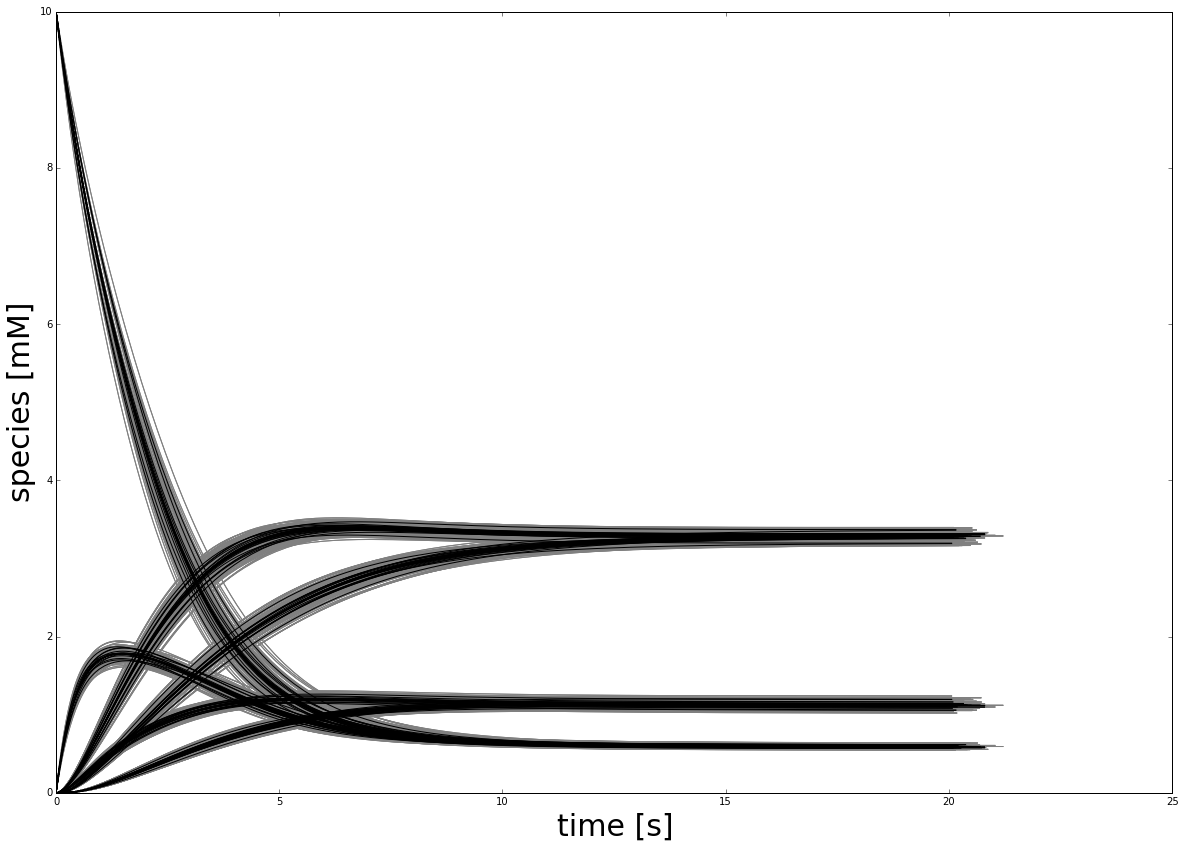

In [37]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations_double:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='grey')
    
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize)